In [1]:
import numpy as np
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pyplot as plt

In [40]:
# Load data
path = '/data/'
data = pd.read_parquet(path+'combined/240411_All/facilityEmissions_all.parquet')

production_file = path+'/processed/icisFacilityProduction.csv'

production = pd.read_csv(production_file, index_col=0)

colors = ['#fc8d59', '#4575b4',  '#d73027', '#91bfdb', '#191922', '#d3d3d3']

year = '2050'

output_path = '/figures/'

In [41]:
yearly_prod = production[['PRODUCT',year]].groupby('PRODUCT').sum().reset_index()

ifa_prod = pd.read_csv(path+'extracted/IFA_production_w_uncertainties.csv')[['PRODUCT', year]].groupby('PRODUCT').sum().reset_index()

name_conversions = {
    'NH3': 'AMMONIA',
    'AN': 'AMMONIUM NITRATE',
    'Ammonium nitrate (33.5-0-0) granulated': 'AMMONIUM NITRATE',
    'AS': 'AMMONIUM SULPHATE',
    'CAN': 'CALCIUM AMMONIUM NITRATE',
    'Calcium ammonium nitrate (27-0-0)': 'CALCIUM AMMONIUM NITRATE',
    'Urea (46-0-0)': 'UREA'
}

ifa_prod['PRODUCT'] = ifa_prod['PRODUCT'].replace(name_conversions)

total_prod = pd.concat((yearly_prod, ifa_prod)).sort_values('PRODUCT').reset_index(drop=True)

total_prod['PRODUCT'] = total_prod['PRODUCT'].str.upper()

In [42]:
def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

data_filt = filter_df(data, ['Gas', 'Type', 'Product type'], [['CO2e_100a'], ['Direct Process', 'Feedstock', 'Direct Utilities', 'Indirect Utilities', 'Primary chemicals', 'Intermediates'], ['Primary chemicals']])

subset = data_filt[['PRODUCT', 'Type', year, year+'_sigma']].groupby(['PRODUCT', 'Type']).sum().reset_index()

In [43]:
used_emissions = subset.copy()
prod_grouping = used_emissions.groupby(['PRODUCT']).sum().reset_index()
prod_grouping['Type'] = 'Total'
used_emissions = pd.concat((used_emissions, prod_grouping)).sort_values('PRODUCT').reset_index(drop=True)
used_emissions = used_emissions.merge(total_prod, on='PRODUCT', how='left')

used_emissions[year] = used_emissions[year+'_x']/used_emissions[year+'_y']
used_emissions[year+'_sigma'] = used_emissions[year+'_sigma']/used_emissions[year+'_y']

In [44]:
data_filt_s = filter_df(data, ['Gas', 'Type', 'Product type'], [['CO2e_100a'], ['IHS CtOG'], ['Primary chemicals']])

subset_s = data_filt_s[['PRODUCT', 'Type', year, year+'_sigma']].groupby(['PRODUCT', 'Type']).sum().reset_index()

subset_s['Type'] = 'Total'

In [45]:
def create_groupings(factors, type='y', columns=None):

    if columns is None:
        columns = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']

    used_emissions = factors[type].reset_index().groupby(['Product type', 'Product group', 'PRODUCT']).sum().reset_index().drop(columns=['Year'])
    used_emissions = used_emissions.merge(total_prod, on='PRODUCT', how='left')

    prod_grouping = used_emissions.copy()
    prod_grouping['Total_val'] = np.sum(used_emissions[columns], axis=1)

    for col in columns:
        prod_grouping[col] = prod_grouping[col]/prod_grouping[year]
    prod_grouping['Total_factor'] = np.sum(prod_grouping[columns], axis=1)

    type_grouping = used_emissions.groupby(['Product type', 'Product group']).sum().reset_index()
    type_grouping['Total_val'] = np.sum(type_grouping[columns], axis=1)
    for col in columns:
        type_grouping[col] = type_grouping[col]/type_grouping[year]
    type_grouping['Total_factor'] = np.sum(type_grouping[columns], axis=1)

    return prod_grouping, type_grouping

In [46]:
def plot_boxes(df, columns, colors, plot_col='Product group', err=True, scale_factor=1/1000, unit='Mt', firstword=False,
               ylabel1='Unit CO$_{2e}$ emissions ', ylabel2='CO$_{2e}$ emissions', plot_bars=True):
    index = range(len(df))
    plt.rcParams.update({'font.size':fontsize})

    values = [df[col] for col in columns]
    labels = columns #['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']
    #colors = ['C1', 'C2', 'c', 'C4', 'C5', 'C6', 'C7']

    if plot_bars:
        ax2 = ax.twinx()

    for enum, (y, z, c) in enumerate(zip(values, labels, colors)):
        pos_bottom = np.sum(np.array(values[:enum]).clip(0), axis=0) if enum > 0 else None
        neg_bottom = np.sum(np.array(values[:enum]).clip(max=0), axis=0) if enum > 0 else None
        bottom = [pos_bottom[num] if val>=0 else neg_bottom[num] for num, val in enumerate(y)] if enum > 0 else None
        p1 = ax.bar(df['Centres']*scale_factor, y, width=df[year]*scale_factor, bottom=bottom, label=z, color=c, alpha=0.96, edgecolor='k')

        ax.xaxis.set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))

        if plot_bars:
            if err:
                p2 = ax2.errorbar(df['Centres']*scale_factor, df['Total_val_x']*scale_factor, yerr=df['Total_val_y']*scale_factor, fmt='o', color='b', ecolor='k', capsize=5, label='Total')
            else:
                p2 = ax2.scatter(df['Centres']*scale_factor, df['Total_val']*scale_factor, color='b', marker='o', edgecolors='k', label='Absolute uncertainty')
                p2 = ax.scatter(1, 1, color='b', marker='o', edgecolors='k', label='Absolute uncertainty')
                # for i, label in enumerate(df['Total_val']*scale_factor):
                #     ax2.annotate(label, ((df['Centres']*scale_factor)[i], (df['Total_val']*scale_factor)[i]), textcoords="offset points", xytext=(0,10), ha='center')
            ax2.tick_params(axis='y', labelcolor='blue', color='blue')
            ax2.spines['right'].set_color('blue')
            ax2.set_ylim(bottom=0)
            ax2.set_ylabel(ylabel2+' ('+unit+')', color='b')
            ax2.grid(axis='y', linestyle='dashed', zorder=-1)
        else: ax.grid(axis='y', linestyle='dashed', zorder=-1)
        #ax2.yaxis.set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))

        # ps = p1+p2
        # labs = [p.get_label() for p in ps]
        # ax.legend(ps, labs)

        if z==labels[-1]:
            if firstword:
                ax.bar_label(p1, labels= [i.split(' ')[0] for i in df[plot_col]], rotation=0)
            else: 
                original_list = [i[:2].upper() for i in df[plot_col]]
                replace_rules = {'PA':'PX', 'OR':'OX', 'MI':'MX'}
                def replace(item):
                    return replace_rules.get(item, item) 
    
                label_list = list(map(replace, original_list))
                ax.bar_label(p1, labels= label_list, rotation=0)

    ax.set_xlabel('Product Output ('+unit+')')
    ax.set_ylabel(ylabel1+'\n(kg CO$_{2e}$/kg)')
    return ax

In [47]:
factors_acc = used_emissions.pivot(index=['PRODUCT'], columns='Type', values=year).reset_index()

factors_acc = factors_acc.merge(used_emissions.groupby('PRODUCT').first().reset_index()[['PRODUCT', year+'_y']], on='PRODUCT', how='inner').sort_values('Total', ascending=False).rename(columns={year+'_y':year})
factors_acc['Cml'] = factors_acc[year].cumsum()
factors_acc['Centres'] = factors_acc['Cml']-factors_acc[year]/2
factors_acc.rename(columns={'Direct Utilities':'Direct Energy Use', 'Indirect Utilities':'Indirect Energy Use'}, inplace=True)

columns = ['Primary chemicals', 'Feedstock', 'Indirect Energy Use', 'Direct Energy Use', 'Direct Process']

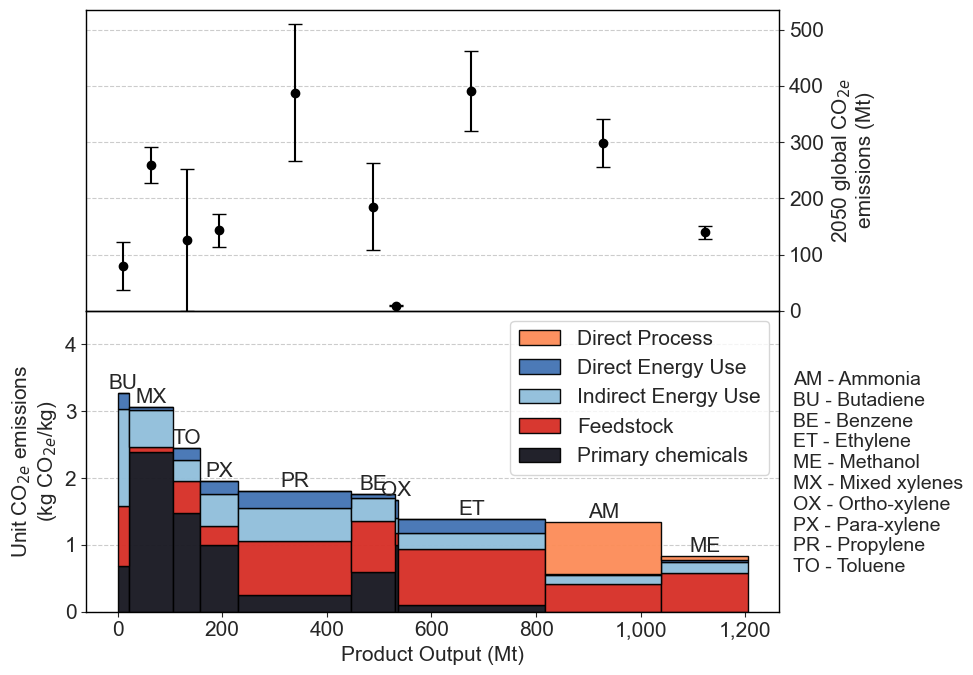

In [48]:
import matplotlib.ticker as ticker

colors = ['#191922', '#d73027', '#91bfdb', '#4575b4', '#fc8d59']

## Create production values figure
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]}, figsize=[10,7], facecolor='white')

width=0.7
fontsize=15

axs[1].grid(None)
axs[0].grid(None)
ax = axs[1]
ax.grid(None)
ax = plot_boxes(factors_acc, columns, colors=colors, plot_col='PRODUCT', plot_bars=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=[1, 1])
ax.text(1.02, 0.8, 'AM - Ammonia\nBU - Butadiene\nBE - Benzene\nET - Ethylene\nME - Methanol\nMX - Mixed xylenes\nOX - Ortho-xylene\nPX - Para-xylene\nPR - Propylene\nTO - Toluene', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox={'boxstyle':'round', 'linestyle':'-', 'facecolor':'w', 'alpha':0.5})

ax.grid(None)
ax.set_ylim([0,4.5])
ax.set_yticks(np.arange(0, 4.5, 1))
ax.grid(axis='y', linestyle='dashed', zorder=10)

axs[0].grid(None)
ax2 = axs[0].twinx()
ax2.grid(None)
df = subset_s.merge(factors_acc[['PRODUCT', 'Centres']], on='PRODUCT')
scale_factor=1/1000
unit = 'Mt'
ylabel2 = year+' global CO$_{2e}$\nemissions'
p2 = ax2.errorbar(df['Centres']*scale_factor, df[year]*scale_factor, yerr=df[year+'_sigma']*scale_factor, fmt='o', color='k', ecolor='k', capsize=5, label='Total')
#ax2.tick_params(axis='y', labelcolor='blue', color='blue')
#ax2.spines['right'].set_color('blue')
ax2.set_ylim(bottom=0)
ax2.set_ylabel(ylabel2+' ('+unit+')')

ax2.grid(axis='y', linestyle='dashed', zorder=0)

axs[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
axs[0].grid(None)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(100))

ax.tick_params(axis='y', which='both', left=True)
ax.tick_params(axis='x', which='both', bottom=True)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
    
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

fig.tight_layout()

In [49]:
# Save output plot
fig.savefig(output_path+'Figure_S7.eps', format='eps', bbox_inches='tight',dpi=300)

# Save output plot
fig.savefig(output_path+'Figure_S7.png', format='png', bbox_inches='tight',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
